
<a href="https://colab.research.google.com/github/NeuroDesk/example-notebooks/blob/main/books/diffusion_imaging/MRtrix_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Google Colab"/>   </a>

# Diffusion Analysis with MRtrix: Part 1 - Preprocessing

This notebook is the first in a series on Diffusion Analysis using MRtrix. In this part, we will focus on loading, viewing and preprocessing steps essential for preparing diffusion MRI data for further analysis. Subsequent parts will cover additional topics, including Constrained Spherical Deconvolution (CSD) methods and tissue estimation and then finally registration and streamline fitting.


__Author:__ Monika Doerig

#### Citation:

__Andy's Brain Book:__

- This MRtrix example is based on the [Diffusion Analysis with MRtrix](https://andysbrainbook.readthedocs.io/en/latest/MRtrix/MRtrix_Introduction.html#) chapter from Andy’s Brain Book (Jahn, 2022. [doi:10.5281/zenodo.5879293](https://zenodo.org/records/5879294))

__Opensource Data from OpenNeuro:__
- Hannelore Aerts and Daniele Marinazzo (2018). BTC_preop. [OpenNeuro Dataset ds001226](https://openneuro.org/datasets/ds001226/versions/00001)

__MRtrix3:__ 
- Tournier, J.-D.; Smith, R. E.; Raffelt, D.; Tabbara, R.; Dhollander, T.; Pietsch, M.; Christiaens, D.; Jeurissen, B.; Yeh, C.-H. & Connelly, A. MRtrix3: A fast, flexible and open software framework for medical image processing and visualisation. NeuroImage, 2019, 202, 116137. https://doi.org/10.1016/j.neuroimage.2019.116137
- For more details: https://www.mrtrix.org/

## Setup Neurodesk

In [1]:
%%capture
import os
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  os.environ["LD_PRELOAD"] = "";
  os.environ["APPTAINER_BINDPATH"] = "/content,/tmp,/cvmfs"
  os.environ["MPLCONFIGDIR"] = "/content/matplotlib-mpldir"
  os.environ["LMOD_CMD"] = "/usr/share/lmod/lmod/libexec/lmod"

  !curl -J -O https://raw.githubusercontent.com/NeuroDesk/neurocommand/main/googlecolab_setup.sh
  !chmod +x googlecolab_setup.sh
  !./googlecolab_setup.sh

  os.environ["MODULEPATH"] = ':'.join(map(str, list(map(lambda x: os.path.join(os.path.abspath('/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/'), x),os.listdir('/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/')))))

In [2]:
# Output CPU information:
!cat /proc/cpuinfo | grep 'vendor' | uniq
!cat /proc/cpuinfo | grep 'model name' | uniq

vendor_id	: GenuineIntel
model name	: Intel(R) Xeon(R) Gold 6126 CPU @ 2.60GHz


### Import Python Modules

In [1]:
%%capture
! pip install nibabel matplotlib

In [2]:
import os
import subprocess
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import tempfile
from ipyniivue import AnyNiivue
from IPython.display import display, Markdown
from ipywidgets import RadioButtons, VBox

## Introduction

MRtrix is a software package for analyzing diffusion data. One of the notable advantages of MRtrix over tensor-fitting techniques is their method of constrained spherical deconvolution, or CSD; this method deconvolves the diffusion signal in each voxel into a series of overlapping fiber bundles. This reduces the problem of crossing fibers that can be a confound when fitting a tensor.

In addition to a library of commands created by the MRtrix team, the software also has wrappers for commands used with FSL: in particular, the commands ```topup``` and ```eddy```. Therefore, we will load the MRtrix and the fMRI software package FSL.

<div style="background-color: #f0f8ff; padding: 10px; border-radius: 5px;">
    <div style="background-color: #add8e6; padding: 5px; border-radius: 5px; font-weight: bold;">
        <span style="font-size: 15px; color: #add8e6; background-color: white; border-radius: 50%; width: 20px; height: 20px; display: inline-block; text-align: center; line-height: 20px;">
            !
        </span> <span style="color: white;">Note:</span>
    </div>
    <p style="margin: 10px 0;">
        Andy's tutorial is based on the steps outlined in the <a href="https://mrtrix.readthedocs.io/en/latest/index.html" style="color: #007bff; text-decoration: none;">MRtrix documentation</a>, especially the “DWI Pre-Processing” and “Constrained Spherical Deconvolution” chapters. Several of the steps and explanations are derived from Marlene Tahedl’s excellent <a href="https://osf.io/ht7zv" style="color: #007bff; text-decoration: none;">BATMAN</a> tutorial, and in many places her file notation is used.
    </p>
    For an introduction to diffusion-weighted MRI, please ensure you read Andy's comprehensive <a href="https://andysbrainbook.readthedocs.io/en/latest/MRtrix/MRtrix_Course/MRtrix_00_Diffusion_Overview.html" style="color: #007bff; text-decoration: none;">MRtrix Introduction</a>.
</div>

### Load packages

In [3]:
import lmod
await lmod.load('mrtrix3/3.0.4')
await lmod.load('fsl/6.0.7.4')
await lmod.list()

['mrtrix3/3.0.4', 'fsl/6.0.7.4']

Try typing one of the commands from the library, such as ```mrconvert```. If MRtrix has been installed correctly, you should see the help page printed by default when no arguments are passed to the command:

In [4]:
! mrconvert | head -n 18

MRtrix 3.0.4                        mrconvert                        Mar 20 2024

     mrconvert: part of the MRtrix3 package

SYNOPSIS

     Perform conversion between different file types and optionally extract a
     subset of the input image

USAGE

     mrconvert [ options ] input output

        input        the input image.

        output       the output image.




If this works without any errors, you are ready to begin downloading diffusion data.

## Downloading the Dataset

For this example, we will be preprocessing a dataset from openneuro.org called [BTC preop](https://openneuro.org/datasets/ds001226/versions/00001). It includes data from patients with gliomas, patients with meningiomas, and a group of control subjects. 

To download the data of one subject, excute the next cell:

In [5]:
PATTERN = "sub-CON02"
! datalad install https://github.com/OpenNeuroDatasets/ds001226.git

! cd ds001226 && datalad get $PATTERN

Cloning:   0%|                             | 0.00/2.00 [00:00<?, ? candidates/s]
Enumerating: 0.00 Objects [00:00, ? Objects/s]
                                              
Counting:   0%|                              | 0.00/25.9k [00:00<?, ? Objects/s]
                                                                                
Compressing:   0%|                           | 0.00/18.7k [00:00<?, ? Objects/s]
                                                                                
Receiving:   0%|                             | 0.00/25.9k [00:00<?, ? Objects/s]
Receiving:   6%|█▏                  | 1.56k/25.9k [00:00<00:01, 15.3k Objects/s]
Receiving:  14%|██▊                 | 3.63k/25.9k [00:00<00:01, 18.0k Objects/s]
Receiving:  25%|█████               | 6.49k/25.9k [00:00<00:00, 22.7k Objects/s]
Receiving:  34%|██████▊             | 8.82k/25.9k [00:00<00:00, 21.6k Objects/s]
Receiving:  53%|██████████▌         | 13.8k/25.9k [00:00<00:00, 31.0k Objects/s]
Receiving:  77%

####
If you want to download more subjects, here is an example how to get 4 controls and 4 patients:
``` 
PATTERN_CONTROLS="sub-CON0[1-4]"
PATTERN_PATIENTS="sub-PAT0[1-4]"

! datalad install https://github.com/OpenNeuroDatasets/ds001226.git

! cd ds001226 && datalad get $PATTERN_CONTROLS $PATTERN_PATIENTS
```



## Looking at the Data
MRtrix uses its own format for storing and displaying imaging data. MRtrix is also able to read raw data in NIFTI format, but will output its files in MRtrix format, labeled with a ```.mif``` extension.

To see how this works, navigate to the folder sub-CON02/ses-preop/dwi, which contains the diffusion data. One of the first steps for preprocessing your data is converting the diffusion data to a format that MRtrix understands; we will use the command ```mrconvert``` to combine the raw diffusion data with its corresponding ```.bval``` and ```.bvec files```, so that we can use the combined file for future preprocessing steps:

In [7]:
! mrconvert ds001226/sub-CON02/ses-preop/dwi/sub-CON02_ses-preop_acq-AP_dwi.nii.gz sub-02_dwi.mif -fslgrad ds001226/sub-CON02/ses-preop/dwi/sub-CON02_ses-preop_acq-AP_dwi.bvec ds001226/sub-CON02/ses-preop/dwi/sub-CON02_ses-preop_acq-AP_dwi.bval

mrconvert: [100%] uncompressing image "ds001226/sub-CON02/ses-preop/dwi/sub-CON02_ses-preop_acq-AP_dwi.nii.gz"[0K
mrconvert: [100%] copying from "ds001226/s...ses-preop_acq-AP_dwi.nii.gz" to "sub-02_dwi.mif"[0K


This command requires three arguments: The input, which is the raw DWI file in the AP directory; an output file, which we will call sub-02_dwi.mif to make it more compact and easier to read; and ```-fslgrad```, which requires the corresponding .bvec and .bval files (in that order).

<div style="background-color: #f0f8ff; padding: 10px; border-radius: 5px;">
    <div style="background-color: #add8e6; padding: 5px; border-radius: 5px; font-weight: bold;">
        <span style="font-size: 15px; color: #add8e6; background-color: white; border-radius: 50%; width: 20px; height: 20px; display: inline-block; text-align: center; line-height: 20px;">
            !
        </span> <span style="color: white;">Note:</span>
    </div>
    <p style="margin: 10px 0;">
To make the rest of the example easier to read as well, use the <code>mv</code> command to rename the .bval and .bvec files:
    </p>
</div>

In [8]:
! mv ds001226/sub-CON02/ses-preop/dwi/sub-CON02_ses-preop_acq-AP_dwi.bvec sub-02_AP.bvec
! mv ds001226/sub-CON02/ses-preop/dwi/sub-CON02_ses-preop_acq-AP_dwi.bval sub-02_AP.bval
! mv ds001226/sub-CON02/ses-preop/dwi/sub-CON02_ses-preop_acq-PA_dwi.bvec sub-02_PA.bvec
! mv ds001226/sub-CON02/ses-preop/dwi/sub-CON02_ses-preop_acq-PA_dwi.bval sub-02_PA.bval

The output image, sub-02_dwi.mif, can be checked with the command ```mrinfo```. The output contains several pieces of information, such as the dimensions of the dataset and the voxel size, along with the commands that were used to generate the current file:

In [9]:
! mrinfo sub-02_dwi.mif

************************************************
Image name:          "sub-02_dwi.mif"
************************************************
  Dimensions:        96 x 96 x 60 x 102
  Voxel size:        2.5 x 2.5 x 2.5 x 8.7
  Data strides:      [ -1 2 3 4 ]
  Format:            MRtrix
  Data type:         signed 16 bit integer (little endian)
  Intensity scaling: offset = 0, multiplier = 1
  Transform:               0.9988    -0.01395     0.04747        -111
                          0.02082      0.9888     -0.1476      -85.88
                         -0.04488      0.1484      0.9879      -56.76
  command_history:   /opt/mrtrix3-3.0.4/bin/mrconvert ds001226/sub-CON02/ses-preop/dwi/sub-CON02_ses-preop_acq-AP_dwi.nii.gz sub-02_dwi.mif -fslgrad ds001226/sub-CON02/ses-preop/dwi/sub-CON02_ses-preop_acq-AP_dwi.bvec ds001226/sub-CON02/ses-preop/dwi/sub-CON02_ses-preop_acq-AP_dwi.bval  (version=3.0.4)
  comments:          TE=1.1e+02;Time=125448.950;phase=1;dwell=0.380
  dw_scheme:         0,0,0,0
 

Note that, since this is a 4-dimensional dataset, the last dimension is time; in other words, this file contains 102 volumes, each one with dimensions of 96 x 96 x 60 voxels. The last dimension of the *Voxel size* field - which in this case has a value of 8.7 - indicates the time it took to acquire each volume, the repetition time, or TR.

#### __Bvals and Bvecs__
The other files we need to check are the ```bvals``` and ```bvecs files```. Briefly, the bvals contain a single number per volume that indicates how large of a diffusion gradient was applied to the data; and the bvecs file contains a triplet of numbers per volume that shows in what directions the gradients were applied. In general, volumes with larger b-values will be more sensitive to diffusion changes, but the images will also be more susceptible to motion and physiological artifacts.

The most important check is to ensure that the number of bvals and the number of bvecs are the same as the number of volumes in the dataset. For example, we can find the number of volumes in the sub-02_dwi.mif dataset by typing:

In [10]:
! mrinfo -size sub-02_dwi.mif | awk '{print $4}'

102


Which returns a value of 102, the number in the 4th field of the dimensions header that corresponds to the number of time-points, or volumes, in the dataset. We then compare this with the number of bvals and bvecs by using ```awk``` to count the number of columns in each text file:

In [11]:
! awk '{print NF; exit}' sub-02_AP.bvec
! awk '{print NF; exit}' sub-02_AP.bval

102
102


<div style="background-color: #f0f8ff; padding: 10px; border-radius: 5px;">
    <div style="background-color: #add8e6; padding: 5px; border-radius: 5px; font-weight: bold;">
        <span style="font-size: 15px; color: #add8e6; background-color: white; border-radius: 50%; width: 20px; height: 20px; display: inline-block; text-align: center; line-height: 20px;">
            !
        </span> <span style="color: white;">Note:</span>
    </div>
    <p style="margin: 10px 0;">
If the number of volumes in your dataset and the number of bvals and bvecs do not match, you should check with your scan technician about the discrepancy; the files may not have been properly uploaded to the server, or maybe the diffusion-weighted image wasn’t acquired correctly.
    </p>
</div>

#### __Visualization__
MRtrix, like the other imaging software packages has its own imaging viewer, called **mrview**. For example, you can view the image that we created above by typing:
``` javascript
mrview sub-02_dwi.mif
```
Detailed instructions on how to use the mrtrix viewer can be found in [Andy's Tutorial](https://andysbrainbook.readthedocs.io/en/latest/MRtrix/MRtrix_Course/MRtrix_03_DataFormats.html#looking-at-the-data-with-mrview).

We will use AnyNiivue for the interactive visualization of 3 different volumes, which can be selected using radio buttons:

In [12]:
# Load the .mif file and choose different volumes
mif_file_path = "sub-02_dwi.mif"
volume_indices = [0, 2, 3]
output_files = []

# Extract frames/volumes with mrconvert into temporary files
for idx in volume_indices:
    with tempfile.NamedTemporaryFile(suffix=".mif", delete=False) as temp_file:
        temp_file.close()  # Close the temp file so subprocess can overwrite it
        output_path = temp_file.name
        output_files.append(output_path)
        subprocess.run(["mrconvert", mif_file_path, "-coord", "3", str(idx), output_path, "-force", "-quiet"])

# Initialize the Niivue viewer
nv = AnyNiivue()

# Define the volumes with opacity set to 0 initially for all but the default layer 0 (opacity = 1.0)
volumes = [
    {"path": output_files[0], "colormap": "gray", "opacity": 1.0},
    {"path": output_files[1], "colormap": "gray", "opacity": 0.0},
    {"path": output_files[2], "colormap": "gray", "opacity": 0.0},
]

# Load all the volumes into the viewer
nv.load_volumes(volumes)

# Function to update the opacity of the layers based on selection
def update_layer(change):
    selected_index = change.new

    # Set opacity to 0 for all volumes
    for volume in nv.volumes:
        volume.opacity = 0.0

    # Set opacity to 1 for the selected volume
    nv.volumes[selected_index].opacity = 1.0

# Create RadioButtons widget for selecting the active layer
layer_selector = RadioButtons(
    options=[
        ("Volume 0", 0),
        ("Volume 2", 1),
        ("Volume 3", 2),
    ],
    description='Select Volume:',
    style={'description_width': 'initial'}
)

# Observe changes in the RadioButtons widget
layer_selector.observe(update_layer, names='value')

# Display the RadioButtons and the AnyNiivue viewer
display(VBox([layer_selector, nv]))


The first volume that is displayed, which has a time-series index of 0 (i.e., 0 indicates the first volumes in the time-series, 1 indicates the second volume, and so on), looks like a typical T2-weighted functional image. We can verify this by comparing it with the b-value for the first volume in the time-series.

If you look at the bval file, note the intensity differences and how they correspond to their respective b-values. 

In [13]:
! cat sub-02_AP.bval

0 0 700 2800 1200 2800 1200 2800 2800 1200 700 2800 2800 1200 2800 700 1200 2800 2800 1200 2800 700 2800 1200 2800 1200 0 2800 700 2800 1200 2800 2800 1200 700 2800 1200 2800 2800 1200 2800 700 2800 1200 2800 1200 2800 700 2800 1200 2800 0 700 2800 1200 2800 1200 2800 2800 1200 700 2800 2800 1200 2800 700 1200 2800 2800 1200 2800 700 2800 1200 2800 1200 0 2800 700 2800 1200 2800 2800 1200 700 2800 1200 2800 2800 1200 2800 700 2800 1200 2800 1200 2800 700 2800 1200 2800 0


## Preprocessing
Diffusion data in particular is susceptible to warping artifacts as a result of the phase-encoding direction: In general, the predominant encoding direction - such as Anterior to Posterior, or AP - will make the anterior part of the brain look more “squished”, as though a strong headwind is blowing from the Anterior direction. The opposite is true of the Posterior to Anterior, or PA, phase-encoding direction. Sometimes these distortions are very subtle, but other times they are conspicuous.

The following are common preprocessing steps done with MRtrix. If you have used the software package FSL to analyze diffusion data, note that some of the FSL commands - such as eddy and topup - are used in some of the MRtrix libraries. 

### dwi_denoise

The first preprocessing step we will do is denoise the data by using MRtrix’s ```dwidenoise``` command. This requires an input and an output argument, and you also have the option to output the noise map with the *-noise* option. For example:

In [14]:
! dwidenoise sub-02_dwi.mif sub-02_den.mif -noise noise.mif

dwidenoise: [100%] preloading data for "sub-02_dwi.mif"[0K
dwidenoise: [100%] running MP-PCA denoising[0K


One quality check is to see whether the residuals load onto any part of the anatomy. If they do, that may indicate that the brain region is disproportionately affected by some kind of artifact or distortion. To calculate this residual, we will use another MRtrix command called ```mrcalc```.

In [15]:
! mrcalc sub-02_dwi.mif sub-02_den.mif -subtract residual.mif

mrcalc: [100%] computing: (sub-02_dwi.mif - sub-02_den.mif)[0K


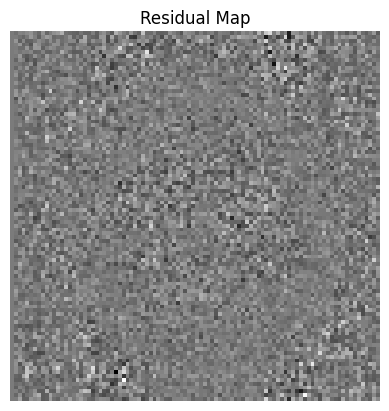

In [16]:
mif_file_path = 'residual.mif'

# Convert the .mif file to a temporary .nii.gz file with -force flag
with tempfile.NamedTemporaryFile(suffix=".nii.gz") as temp_file:
    result = subprocess.run(["mrconvert", mif_file_path, temp_file.name, "-force"], capture_output=True, text=True)

    # Check for errors in the conversion process
    if result.returncode != 0:
        print(f"Error in mrconvert: {result.stderr}")
    else:
        # Load the temporary NIfTI file
        nii_image = nib.load(temp_file.name)
        data = nii_image.get_fdata()

        # Define volume and slice indices
        vol_idx = 0  
        slice_index = data.shape[2] // 2 

        fig, ax = plt.subplots()
        # Extract the middle slice from the selected volume and rotate it 90°
        rotated_slice = np.rot90(data[:, :, slice_index, vol_idx])
        ax.imshow(rotated_slice, cmap="gray")
        ax.set_title("Residual Map")
        ax.axis("off")
        plt.show()

It is common to see a grey outline of the brain, as in the figure above. However, everything within the grey matter and white matter should be relatively uniform and blurry; if you see any clear anatomical landmarks, such as individual gyri or sulci, that may indicate that those parts of the brain have been corrupted by noise. If that happens, you can increase the extent of the denoising filter from the default of 5 to a larger number, such as 7; e.g.,

```javascript
! dwidenoise your_data.mif your_data_denoised_7extent.mif -extent 7 -noise noise.mif
```

### mri_degibbs

An optional preprocessing step is to run ```mri_degibbs```, which removes Gibbs’ ringing artifacts from the data. These artifacts look like ripples in a pond, and are most conspicuous in the images that have a b-value of 0. Look at your diffusion data first, and determine whether there are any Gibbs artifacts; if there are, then you can run mrdegibbs by specifying both an input file and output file, e.g.:

```javascript
! mrdegibbs sub-02_den.mif sub-02_den_unr.mif
```

As always, inspect the data both before and after with mrview to determine whether the preprocessing step made the data better, worse, or had no effect.

If you don’t see any Gibbs artifacts in your data, then I would recommend omitting this step; we won’t be using it for the rest of the tutorial.

### dwipreproc

Most diffusion datasets are composed of two separate imaging files: One that is acquired with a primary phase-encoding direction, and one that is acquired with a reverse phase-encoding direction. The primary phase-encoding direction is used to acquire the majority of the diffusion images at different b-values. The reverse-phase encoded file, on the other hand, is used to unwarp any of the distortions that are present in the primary phase-encoded file.

Our first step is to convert the reverse phase-encoded NIFTI file into .mif format. We will also add its b-values and b-vectors into the header:

In [17]:
! mrconvert ds001226/sub-CON02/ses-preop/dwi/sub-CON02_ses-preop_acq-PA_dwi.nii.gz PA.mif
! mrconvert PA.mif -fslgrad sub-02_PA.bvec sub-02_PA.bval - | mrmath - mean mean_b0_PA.mif -axis 3

mrconvert: [100%] uncompressing image "ds001226/sub-CON02/ses-preop/dwi/sub-CON02_ses-preop_acq-PA_dwi.nii.gz"[0K
mrconvert: [100%] copying from "ds001226/s...ses-preop_acq-PA_dwi.nii.gz" to "PA.mif"[0K
mrconvert: [100%] copying from "PA.mif" to "/tmp/mrtrix-tmp-XPdyxb.mif"[0K
mrmath: [100%] preloading data for "/tmp/mrtrix-tmp-XPdyxb.mif"[0K
mrmath: [100%] computing mean along axis 3...[0K


Next, we extract the b-values from the primary phase-encoded image, and then combine the two with ```mrcat```. This will create a new image, “b0_pair.mif”, which contains both of the average b=0 images for both phase-encoded images.

In [18]:
! dwiextract sub-02_den.mif - -bzero | mrmath - mean mean_b0_AP.mif -axis 3
! mrcat mean_b0_AP.mif mean_b0_PA.mif -axis 3 b0_pair.mif

dwiextract: [100%] extracting volumes[0K
mrmath: [100%] preloading data for "/tmp/mrtrix-tmp-e0ckYi.mif"[0K
mrmath: [100%] computing mean along axis 3...[0K
mrcat: [100%] concatenating "mean_b0_AP.mif"[0K
mrcat: [100%] concatenating "mean_b0_PA.mif"[0K


##### 
We now have everything we need to run the main preprocessing step, which is called by ```dwipreproc```. For the most part, this command is a wrapper that uses FSL commands such as ```topup``` and ```eddy``` to unwarp the data and remove eddy currents.

The first arguments are the input and output; the second option, *-nocleanup*, will keep the temporary processing folder which contains a few files we will examine later. *-pe_dir AP* signalizes that the primary phase-encoding direction is anterior-to-posterior, and *-rpe_pair* combined with the *-se_epi* options indicates that the following input file (i.e., “b0_pair.mif”) is a pair of spin-echo images that were acquired with reverse phase-encoding directions. 

Lastly, *-eddy_options* specifies options that are specific to the FSL command ```eddy```. You can visit the eddy user guide for more options and details about what they do. For now, we will only use the options *--slm=linear* (which can be useful for data that was acquired with less than 60 directions) and *--data_is_shelled* (which indicates that the diffusion data was acquired with multiple b-values).

#####

In [19]:
! dwifslpreproc sub-02_den.mif sub-02_den_preproc.mif -nocleanup -pe_dir AP -rpe_pair -se_epi b0_pair.mif -eddy_options " --slm=linear --data_is_shelled"

dwifslpreproc: 
dwifslpreproc: Note that this script makes use of commands / algorithms that have relevant articles for citation; INCLUDING FROM EXTERNAL SOFTWARE PACKAGES. Please consult the help page (-help option) for more information.
dwifslpreproc: 
dwifslpreproc: Generated scratch directory: /data/books/diffusion_imaging/dwifslpreproc-tmp-ILH2V4/
Command:  mrconvert /data/books/diffusion_imaging/sub-02_den.mif /data/books/diffusion_imaging/dwifslpreproc-tmp-ILH2V4/dwi.mif -json_export /data/books/diffusion_imaging/dwifslpreproc-tmp-ILH2V4/dwi.json
Command:  mrconvert /data/books/diffusion_imaging/b0_pair.mif /data/books/diffusion_imaging/dwifslpreproc-tmp-ILH2V4/se_epi.mif
dwifslpreproc: Changing to scratch directory (/data/books/diffusion_imaging/dwifslpreproc-tmp-ILH2V4/)
dwifslpreproc: Total readout time not provided at command-line; assuming sane default of 0.1
Command:  mrinfo dwi.mif -export_grad_mrtrix grad.b
Command:  mrconvert se_epi.mif topup_in.nii -import_pe_table se_

####
When it has finished running, examine the output to see how eddy current correction and unwarping have changed the data; ideally, you should see more signal restored in regions such as the orbitofrontal cortex, which is particularly susceptible to signal dropout.

Let's display the newly preprocessed data (gray) as well as the original diffusion data ocolored in red. You should see a noticeable difference between the two images, especially in the frontal lobes of the brain near the eyes, which are most susceptible to eddy currents.

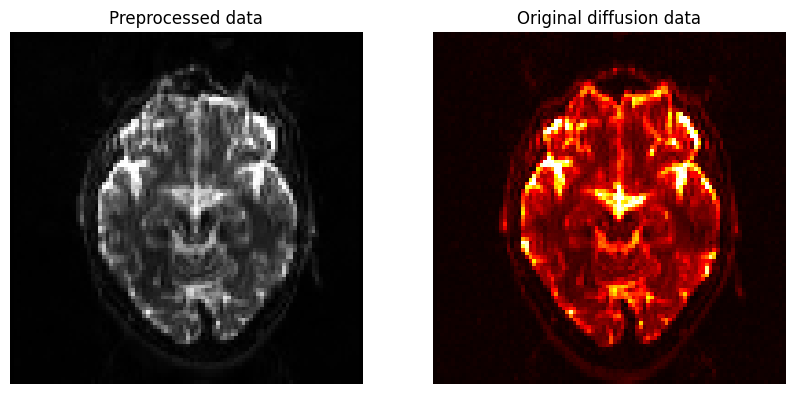

In [20]:
# File paths for both images
mif_file_path1 = 'sub-02_den_preproc.mif'
mif_file_path2 = 'sub-02_dwi.mif'

# Convert both .mif files to temporary .nii.gz files with -force flag
with tempfile.NamedTemporaryFile(suffix=".nii.gz") as temp_file1, \
     tempfile.NamedTemporaryFile(suffix=".nii.gz") as temp_file2:
         
    # Convert main image
    result1 = subprocess.run(["mrconvert", mif_file_path1, temp_file1.name, "-force"], capture_output=True, text=True)
    if result1.returncode != 0:
        print(f"Error in mrconvert for preprocessed image: {result1.stderr}")
        exit()
    
    # Convert overlay image
    result2 = subprocess.run(["mrconvert", mif_file_path2, temp_file2.name, "-force"], capture_output=True, text=True)
    if result2.returncode != 0:
        print(f"Error in mrconvert for original image: {result2.stderr}")
        exit()
         
    # Load the converted images
    nii_image1 = nib.load(temp_file1.name)
    nii_image2 = nib.load(temp_file2.name)

    data1 = nii_image1.get_fdata()
    data2 = nii_image2.get_fdata()

    # Select middle slice 
    slice_index = data1.shape[2] // 3

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    # Plot preprocessed data
    axes[0].imshow(np.rot90(data1[:, :, slice_index, 0]), cmap="Greys_r", vmin=0, vmax=1000)
    axes[0].set_title("Preprocessed data")
    axes[0].axis("off")

    # Plot original diffusion data
    axes[1].imshow(np.rot90(data2[:, :, slice_index, 0]), cmap="hot", alpha=1.0, vmin=0, vmax=1000) 
    axes[1].set_title("Original diffusion data")
    axes[1].axis("off")
    plt.show()

#### Checking for Corrupt Slices

One of the options in the ```dwifslpreproc``` command, *-nocleanup*, retained a directory with the string “tmp” in its title. Within this folder is a file called "dwi_post_eddy.eddy_outlier_map", which contains strings of 0’s and 1’s. Each 1 represents a slice that is an outlier, either because of too much motion, eddy currents, or something else.

The following code will navigate into the “tmp” folder and calculate the percentage of outlier slices:

In [21]:
! cd dwifslpreproc-tmp-* && \
  totalSlices=$(mrinfo dwi.mif | grep Dimensions | awk '{print $6 * $8}') && \
  totalOutliers=$(awk '{ for(i=1;i<=NF;i++) sum+=$i } END { print sum }' dwi_post_eddy.eddy_outlier_map) && \
  percentageOutliers=$(awk "BEGIN { print ($totalOutliers / $totalSlices * 100) }") && \
  echo "If the following number is greater than 10, you may have to discard this subject because of too much motion or corrupted slices:" && \
  echo "$percentageOutliers" | tee percentageOutliers.txt

If the following number is greater than 10, you may have to discard this subject because of too much motion or corrupted slices:
0.522876


The first two lines navigate into the “tmp” directory and calculate the total number of slices by multiplying the number of slices for a single volume by the total number of volumes in the dataset. The total number of 1’s in the outlier map is then calculated, and the percentage of outlier slices is generated by dividing the number of outlier slices by the total number of slices. If this number is greater than 10 - i.e., if more than 10 percent of the slices are flagged as outliers - you should consider removing the subject from further analyses.

### Generating a Mask
As with fMRI analysis, it is useful to create a mask to restrict your analysis only to brain voxels; this will speed up the rest of your analyses.

To do that, it can be useful to run a command beforehand called ```dwibiascorrect```. This can remove inhomogeneities detected in the data that can lead to a better mask estimation. However, it can in some cases lead to a worse estimation; as with all of the preprocessing steps, you should check it before and after each step:

<div style="background-color: #f0f8ff; padding: 10px; border-radius: 5px;">
    <div style="background-color: #add8e6; padding: 5px; border-radius: 5px; font-weight: bold;">
        <span style="font-size: 15px; color: #add8e6; background-color: white; border-radius: 50%; width: 20px; height: 20px; display: inline-block; text-align: center; line-height: 20px;">
            !
        </span> <span style="color: white;">Note:</span>
    </div>
    <p style="margin: 10px 0;">
The following command uses the <code>-ants</code> option, which requires that ANTs is loaded as well. Another option is FSL, then you can replace it with the <code>-fsl</code> option.
    </p>
</div>

In [22]:
await lmod.load('ants/2.3.5')
await lmod.list()

['mrtrix3/3.0.4', 'fsl/6.0.7.4', 'ants/2.3.5']

In [23]:
! dwibiascorrect ants sub-02_den_preproc.mif sub-02_den_preproc_unbiased.mif -bias bias.mif

dwibiascorrect: 
dwibiascorrect: Note that this script makes use of commands / algorithms that have relevant articles for citation; INCLUDING FROM EXTERNAL SOFTWARE PACKAGES. Please consult the help page (-help option) for more information.
dwibiascorrect: 
dwibiascorrect: Generated scratch directory: /data/books/diffusion_imaging/dwibiascorrect-tmp-MVN0VJ/
Command:  mrconvert /data/books/diffusion_imaging/sub-02_den_preproc.mif /data/books/diffusion_imaging/dwibiascorrect-tmp-MVN0VJ/in.mif
dwibiascorrect: Changing to scratch directory (/data/books/diffusion_imaging/dwibiascorrect-tmp-MVN0VJ/)
Command:  dwi2mask in.mif mask.mif
Command:  dwiextract in.mif - -bzero | mrmath - mean mean_bzero.mif -axis 3
Command:  mrconvert mean_bzero.mif mean_bzero.nii -strides +1,+2,+3
Command:  mrconvert mask.mif mask.nii -strides +1,+2,+3
Command:  N4BiasFieldCorrection -d 3 -i mean_bzero.nii -w mask.nii -o [corrected.nii,init_bias.nii] -s 4 -b [100,3] -c [1000,0.0]
Command:  mrcalc mean_bzero.mif ma

You are now ready to create the mask with ```dwi2mask```, which will restrict your analysis to voxels that are located within the brain:

In [24]:
! dwi2mask sub-02_den_preproc_unbiased.mif mask.mif

dwi2mask: [100%] preloading data for "sub-02_den_preproc_unbiased.mif"[0K
dwi2mask: [done] computing dwi brain mask[0K
dwi2mask: [done] applying mask cleaning filter[0K


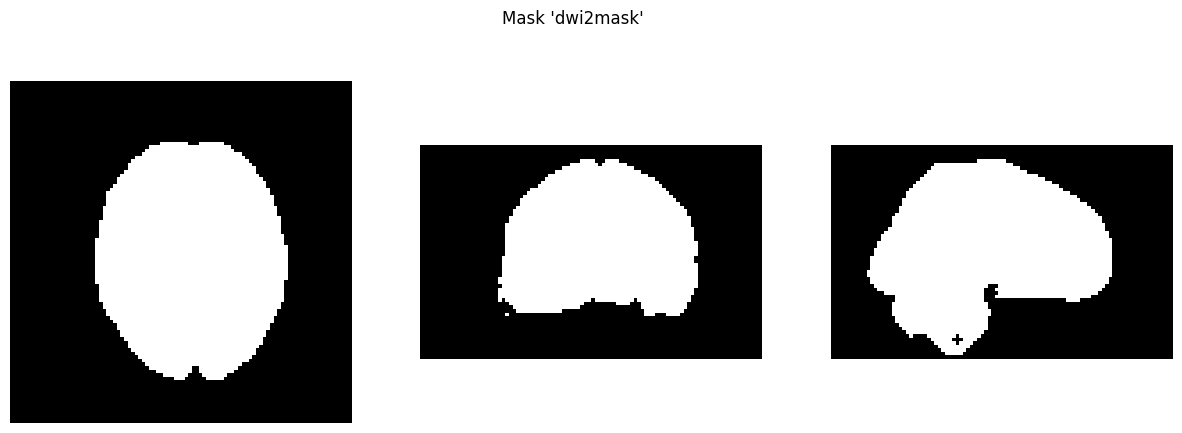

In [26]:
mif_file_path = 'mask.mif'

with tempfile.NamedTemporaryFile(suffix=".nii.gz") as temp_file:
    result = subprocess.run(["mrconvert", mif_file_path, temp_file.name, "-force"], capture_output=True, text=True)

    # Check for errors in the conversion process
    if result.returncode != 0:
        print(f"Error in mrconvert: {result.stderr}")
    else:
        # Load the temporary NIfTI file
        nii_image = nib.load(temp_file.name)
        data = nii_image.get_fdata()
        
        slice_idx1 = data.shape[2] // 2
        slice_idx2 = data.shape[1] // 2
        slice_idx3 = data.shape[0] // 2

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(np.rot90(data[:, :, slice_idx1]), cmap="gray")
        axes[0].axis("off")
        axes[1].imshow(np.rot90(data[:, slice_idx2, :]), cmap="gray")
        axes[1].axis("off")
        axes[2].imshow(np.rot90(data[slice_idx3, :, :]), cmap="gray")
        axes[2].axis("off")

        plt.suptitle("Mask 'dwi2mask'")
        plt.show()

MRtrix’s ```dwi2mask``` command works well in most scenarios. However, you can see from the above image that there are holes in the mask. You may be uninterested in these regions, but it is still a good idea to make sure the mask doesn’t have any holes anywhere.

To that end, you could use a command such as FSL’s bet2. For example, you could use the following code to convert the unbiased diffusion-weighted image to NIFTI format, create a mask with bet2, and then convert the mask to .mif format.
You may have to experiment with the fractional intensity threshold (specified by -f) in order to generate a mask that you are satisfied with.

In [27]:
!  mrconvert sub-02_den_preproc_unbiased.mif sub-02_unbiased.nii.gz
!  bet2 sub-02_unbiased.nii.gz sub-02_masked -m -f 0.5
!  mrconvert sub-02_masked_mask.nii.gz mask_bet.mif

mrconvert: [100%] copying from "sub-02_den_preproc_unbiased.mif" to "sub-02_unbiased.nii.gz"[0K
mrconvert: [100%] compressing image "sub-02_unbiased.nii.gz"[0K
mrconvert: [100%] uncompressing image "sub-02_masked_mask.nii.gz"[0K
mrconvert: [100%] copying from "sub-02_masked_mask.nii.gz" to "mask_bet.mif"[0K


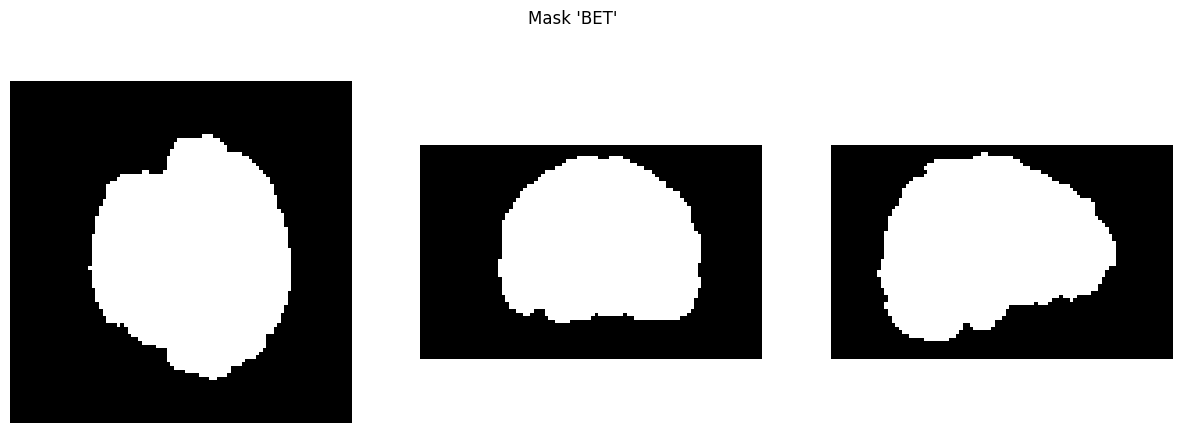

In [28]:
# Load the NIfTI file
nii_image = nib.load('sub-02_masked_mask.nii.gz')
data = nii_image.get_fdata()

# Define volume indices for the three volumes you want to display
slice_idx1 = data.shape[2] // 2
slice_idx2 = data.shape[1] // 2
slice_idx3 = data.shape[0] // 2  

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(np.rot90(data[:, :, slice_idx1]), cmap="gray")
axes[0].axis("off")
axes[1].imshow(np.rot90(data[:, slice_idx2, :]), cmap="gray")
axes[1].axis("off")
axes[2].imshow(np.rot90(data[slice_idx3, :, :]), cmap="gray")
axes[2].axis("off")

plt.suptitle("Mask 'BET'")
plt.show()

Alternatively, inspect the mask using **AnyNiivue**:

In [29]:
nv2 = AnyNiivue()
nv2.load_volumes([{ "path": 'mask_bet.mif'}])

display(Markdown("### Mask 'Bet'"))
display(nv2)


### Mask 'Bet'

AnyNiivue()